# Redes Neuronales NLP

In [1]:
import pandas as pd
import sklearn as sklearn

In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [4]:
import os

df=pd.read_excel(
     os.path.join("data", "reclamos_20201221_con_clas.xlsx"),
     engine='openpyxl',
)

In [5]:
df.columns

Index(['CASO_ID', 'MERCADO_ANALISTA', 'DESCRIPCION_CIUDADANO',
       'PETICION_CIUDADANO'],
      dtype='object')

In [6]:
df['MERCADO_ANALISTA']=df['MERCADO_ANALISTA'].astype('category')

In [7]:
df=df[['MERCADO_ANALISTA','PETICION_CIUDADANO','DESCRIPCION_CIUDADANO']].dropna()

In [8]:
df['DESCRIPCION_CIUDADANO']=df['DESCRIPCION_CIUDADANO'].map(str).str.lower()
df['PETICION_CIUDADANO']=df['PETICION_CIUDADANO'].map(str).str.lower() 

In [9]:
df['data'] = df['DESCRIPCION_CIUDADANO'] + df['PETICION_CIUDADANO']

In [10]:
import string, re

def remove_punct(x):
    comp = re.compile("[%s\d]" % re.escape(string.punctuation))
    return " ".join(comp.sub(" ", str(x)).split()).lower()

df['data']=df['data'].apply(remove_punct)

In [11]:
import spacy
import es_core_news_sm

nlp = es_core_news_sm.load()

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/sergio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from nltk.corpus import stopwords

stop_words=stopwords.words('spanish')
def preprocess(text):
  	# Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stop_words]
    
    return ' '.join(a_lemmas)
  
# Apply preprocess to ted['transcript']
df['data'] = df['data'].apply(preprocess)
print(df['data'] )

0      recibi correar electronico indicar zurich sant...
1      nombrar ser xx día enero año entregar carta an...
2      estimar señor svs fecho octubre decir bajo seg...
3      primero instancia solicitar renvar tarjeta cue...
4      reclamar scotiabank cobro mantención producto ...
                             ...                        
994    estimar favor revisar procesar fusión itau cor...
995    fecho febrero ser protestar cheque rescatar se...
996    mal calcular valor póliza ahorrar error tipo c...
997    estimar svs fecho haber anular orden venta eje...
998    tener traspasar do mil quinientas accionar com...
Name: data, Length: 999, dtype: object


In [14]:
import unicodedata

def strip_accents(string, accents=('COMBINING ACUTE ACCENT', 'COMBINING GRAVE ACCENT', 'COMBINING TILDE')):
    accents = set(map(unicodedata.lookup, accents))
    chars = [c for c in unicodedata.normalize('NFD', string) if c not in accents]
    return unicodedata.normalize('NFC', ''.join(chars))

df['data'] = df['data'].apply(strip_accents)
print(df['data'] )

0      recibi correar electronico indicar zurich sant...
1      nombrar ser xx dia enero ano entregar carta an...
2      estimar senor svs fecho octubre decir bajo seg...
3      primero instancia solicitar renvar tarjeta cue...
4      reclamar scotiabank cobro mantencion producto ...
                             ...                        
994    estimar favor revisar procesar fusion itau cor...
995    fecho febrero ser protestar cheque rescatar se...
996    mal calcular valor poliza ahorrar error tipo c...
997    estimar svs fecho haber anular orden venta eje...
998    tener traspasar do mil quinientas accionar com...
Name: data, Length: 999, dtype: object


In [15]:
labels=(df['MERCADO_ANALISTA']=='Reclamo Valores').astype(int)

In [16]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['data'].values)

input_array = tokenizer.texts_to_sequences(df['data'].values)

vocab_size = len(tokenizer.word_index) + 1  

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100

input_array = pad_sequences(input_array, padding='post', maxlen=maxlen)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_array, labels, test_size=0.2)

# Red Neuronal Recurrente

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, SpatialDropout1D,GlobalMaxPool1D

embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          688600    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 691,865
Trainable params: 691,865
Non-trainable params: 0
_________________________________________________________________


El modelo recurrente tiende a decrecer la performance. Una alternativa es utilizar embeddings pre-entranados

https://realpython.com/python-keras-text-classification/#what-is-a-word-embedding

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout


embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(LSTM(64,return_sequences=False, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          688600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 730,905
Trainable params: 730,905
Non-trainable params: 0
_________________________________________________________________


In [32]:
batch_size = 16
history=model.fit(X_train,y_train,epochs=10,batch_size=batch_size,validation_data=(X_test, y_test),verbose=1)

Epoch 1/10
50/50 [==============================] - 0s 8ms/step - loss: 0.6425 - accuracy: 0.6721 - val_loss: 0.6365 - val_accuracy: 0.6250
Epoch 2/10
50/50 [==============================] - 0s 7ms/step - loss: 0.5605 - accuracy: 0.6721 - val_loss: 0.5579 - val_accuracy: 0.6250
Epoch 3/10
50/50 [==============================] - 0s 7ms/step - loss: 0.4106 - accuracy: 0.7747 - val_loss: 0.3598 - val_accuracy: 0.8950
Epoch 4/10
50/50 [==============================] - 0s 7ms/step - loss: 0.2073 - accuracy: 0.9675 - val_loss: 0.1995 - val_accuracy: 0.9450
Epoch 5/10
50/50 [==============================] - 0s 7ms/step - loss: 0.1034 - accuracy: 0.9762 - val_loss: 0.1400 - val_accuracy: 0.9550
Epoch 6/10
50/50 [==============================] - 0s 7ms/step - loss: 0.0629 - accuracy: 0.9837 - val_loss: 0.1217 - val_accuracy: 0.9600
Epoch 7/10
50/50 [==============================] - 0s 7ms/step - loss: 0.0416 - accuracy: 0.9937 - val_loss: 0.1130 - val_accuracy: 0.9600
Epoch 8/10
50/50 [==

In [21]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento')
    plt.plot(x, val_acc, 'r', label='Validacion')
    plt.title('Exactitud')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Validacion')
    plt.title('Objetivo')
    plt.legend()

Exactitud Entrenamiento: 1.0000
Exactitud Testing:  0.9650


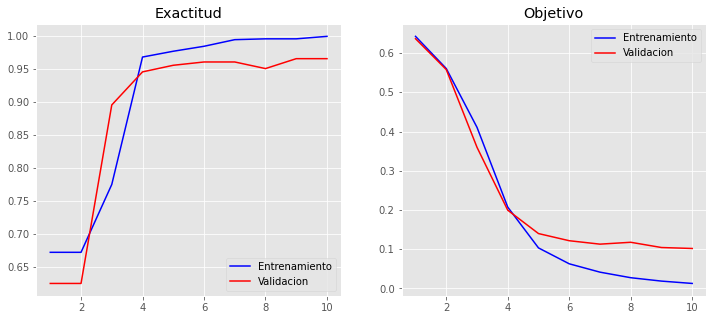

In [33]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Exactitud Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Exactitud Testing:  {:.4f}".format(accuracy))
plot_history(history)

In [34]:
import numpy as np
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print(classification_report(y_test, np.int32(y_pred>0.5)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       125
           1       0.99      0.92      0.95        75

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



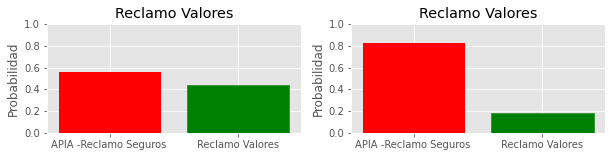

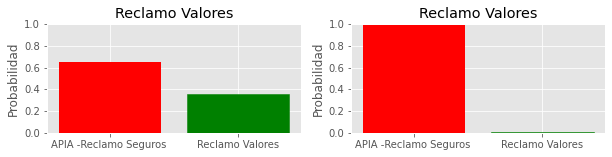

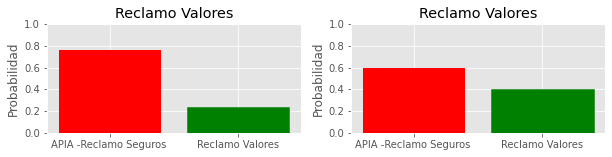

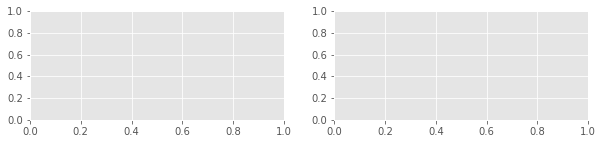

In [35]:
class_error=np.int32(y_pred>0.5).flatten()!=y_test
err_pred=y_pred[class_error]
err_pred=np.hstack([1-err_pred,err_pred])
true_label=y_test[class_error]
n_error=len(true_label)
str_labels=df['MERCADO_ANALISTA'].unique()

for i in range(1,n_error+1,2):
    fig, ax = plt.subplots(1,2,figsize=(10, 2))
    for j in range(2):
        if(i+j<n_error):
            bar=ax[j].bar(str_labels, err_pred[i+j], color='red')
            bar[int(true_label.iloc[i])].set_color('green')
            ax[j].set_title(str_labels[int(true_label.iloc[i+j])])
            ax[j].set_ylim([0, 1])
            ax[j].set_ylabel('Probabilidad')
plt.show()

# Red Neuronal Recurrente Probabilista

In [36]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, SpatialDropout1D,GlobalMaxPool1D

embedding_dim = 100

tfd = tfp.distributions
tfpl = tfp.layers

divergence_fn = lambda q , p , _ : tfd.kl_divergence(q,p)/X_train.shape[0]

def prior(kernel_size,bias_size,dtype=None):
    n=kernel_size+bias_size
    prior_model=Sequential([
        tfpl.DistributionLambda(
        lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n),scale_diag=tf.ones(n)))
    ])
    return prior_model


def posterior(kernel_size,bias_size,dtype=None):
    n=kernel_size+bias_size
    posterior_model=Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n),dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

model = Sequential([
    Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen),
    GlobalMaxPool1D(),
    tfpl.DenseVariational(units=64,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0],
                          activation='relu'),
    tfpl.DenseVariational(units=tfpl.IndependentBernoulli.params_size(1),
                          activation=None,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0]),
    tfpl.IndependentBernoulli(1)
])
model.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          688600    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_variational (DenseVari (None, 64)                20901344  
_________________________________________________________________
dense_variational_1 (DenseVa (None, 1)                 2210      
_________________________________________________________________
independent_bernoulli (Indep ((None, 1), (None, 1))    0         
Total params: 21,592,154
Trainable params: 21,592,154
Non-trainable params: 0
_________________________________________________________________


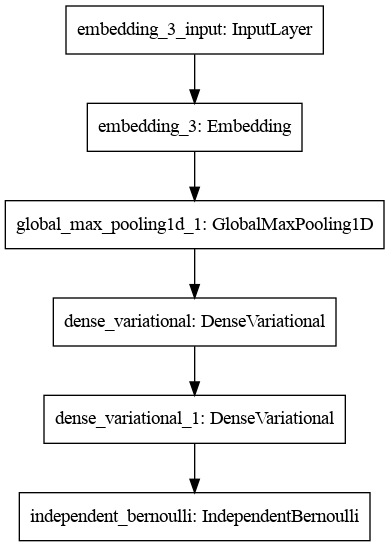

In [37]:
from tensorflow.keras.utils import plot_model

plot_model(model,to_file="variational_embedding.png",dpi=96)

In [42]:
from tensorflow.keras.optimizers import RMSprop,Adam

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(optimizer='adam',
              loss=nll,
              metrics=['accuracy'])

In [ ]:
batch_size =32
history=model.fit(X_train,y_train,epochs=100,batch_size=batch_size,validation_data=(X_test, y_test),verbose=0)

In [40]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False,batch_size=16)
print("Exactitud Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False,batch_size=16)
print("Exactitud Testing:  {:.4f}".format(accuracy))
plot_history(history)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [41]:
y_pred = model.predict(X_test)

print(classification_report(y_test, np.int32(y_pred>0.5)))

              precision    recall  f1-score   support

           0       0.68      0.46      0.55       125
           1       0.42      0.64      0.51        75

    accuracy                           0.53       200
   macro avg       0.55      0.55      0.53       200
weighted avg       0.58      0.53      0.53       200



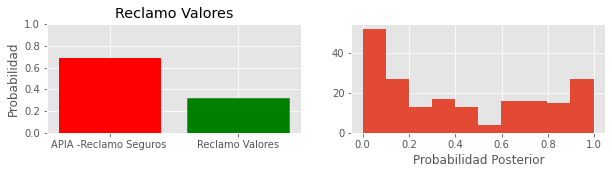

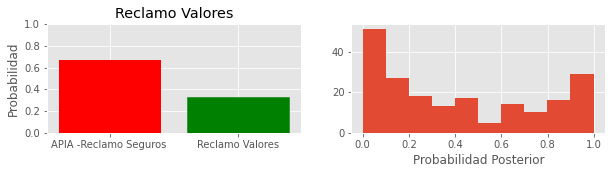

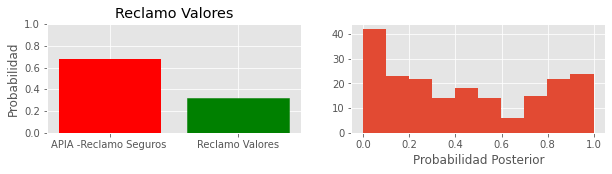

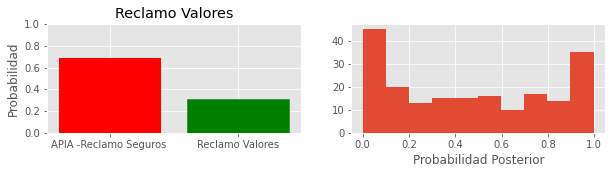

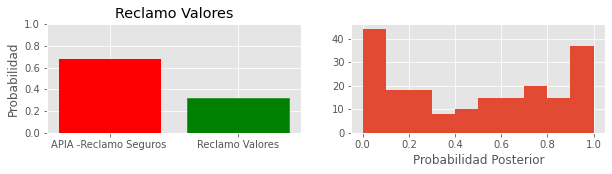

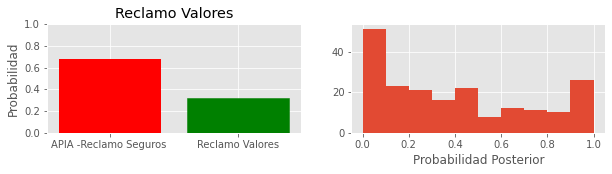

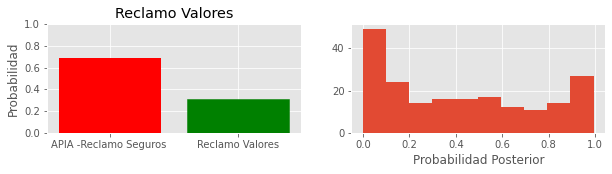

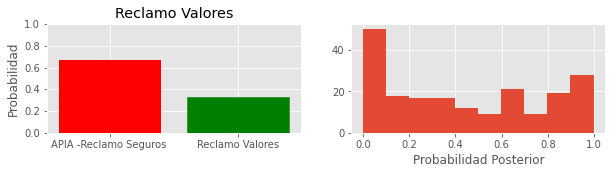

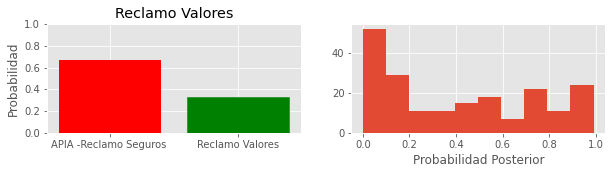

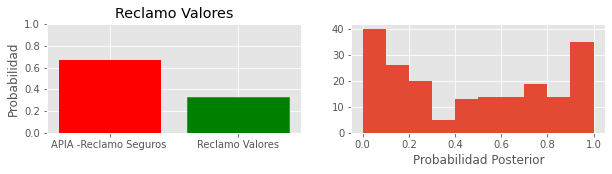

In [39]:
y_pred=model(X_test).mean().numpy()
class_error=np.int32(y_pred>0.5).flatten()!=y_test
err_pred=y_pred[class_error]
err_pred=np.hstack([1-err_pred,err_pred])
true_label=y_test[class_error]
X_error=X_test[class_error]
n_error=len(true_label)
str_labels=df['MERCADO_ANALISTA'].unique()

for i in range(10):
    predicted_probabilities=[]
    for _ in range(200):
        predicted_probabilities.append(model(X_error[i][np.newaxis, ...]).mean().numpy()[0])
    predicted_probabilities=np.stack(predicted_probabilities).flatten()
    fig, ax = plt.subplots(1,2,figsize=(10, 2))
    bar=ax[0].bar(str_labels, err_pred[i], color='red')
    bar[int(true_label.iloc[i])].set_color('green')
    ax[0].set_title(str_labels[int(true_label.iloc[i+j])])
    ax[0].set_ylim([0, 1])
    ax[0].set_ylabel('Probabilidad')
    ax[1].hist(predicted_probabilities)
    ax[1].set_xlabel('Probabilidad Posterior')
plt.show()

# Embeddings Pre-entrenados

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
wordvectors_file_vec = '/content/drive/MyDrive/Colab Notebooks/data/glove-sbwc.i25.vec'
cantidad = 100000
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=cantidad)